## Credit Card Kaggle Anamoly Detection

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### Inspiration
Identify fraudulent credit card transactions.


### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.


In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [2]:
data = pd.read_csv("/content/creditcard.csv.csv", sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,82802.628454,-0.541007,-0.583123,0.437018,-1.369133,-0.564310,0.684361,0.016415,0.501471,0.336367,...,0.418194,1.044784,0.040108,0.202268,-0.895405,0.397246,-0.335082,1.039046,699.534930,0
1,12402.859316,0.019600,0.596081,0.394820,1.469213,0.102883,-0.601788,0.959174,2.158886,-1.401292,...,0.676872,-0.196908,-0.012649,0.076124,1.883004,-2.067351,0.772574,0.470844,656.326441,0
2,9046.947488,1.328166,0.867394,-0.580164,1.430624,0.195366,-0.704315,0.611995,0.412981,0.167513,...,-0.356175,0.519396,-0.213854,1.076086,2.306483,0.082563,-0.944848,-1.443422,879.086521,0
3,60603.001710,3.112910,-0.705317,1.312208,0.378354,0.967779,-0.501367,-0.821389,0.616501,-0.612904,...,0.790421,0.429239,1.597988,-1.795097,-0.876482,-0.262036,0.607088,-1.730730,45.667282,0
4,171065.128157,-0.034551,-0.028817,-0.921718,-1.442854,-1.225308,-0.912963,2.861139,-0.416484,-0.490050,...,0.313216,-0.521431,0.228576,0.101066,1.356683,-0.344029,-0.019738,0.237951,230.353929,0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5000 non-null   float64
 1   V1      5000 non-null   float64
 2   V2      5000 non-null   float64
 3   V3      5000 non-null   float64
 4   V4      5000 non-null   float64
 5   V5      5000 non-null   float64
 6   V6      5000 non-null   float64
 7   V7      5000 non-null   float64
 8   V8      5000 non-null   float64
 9   V9      5000 non-null   float64
 10  V10     5000 non-null   float64
 11  V11     5000 non-null   float64
 12  V12     5000 non-null   float64
 13  V13     5000 non-null   float64
 14  V14     5000 non-null   float64
 15  V15     5000 non-null   float64
 16  V16     5000 non-null   float64
 17  V17     5000 non-null   float64
 18  V18     5000 non-null   float64
 19  V19     5000 non-null   float64
 20  V20     5000 non-null   float64
 21  V21     5000 non-null   float64
 22  

## Exploratory Data Analysis

In [6]:
data.isnull().values.any()

False

<ipython-input-7-5480d8ee9915>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


Text(0, 0.5, 'Frequency')

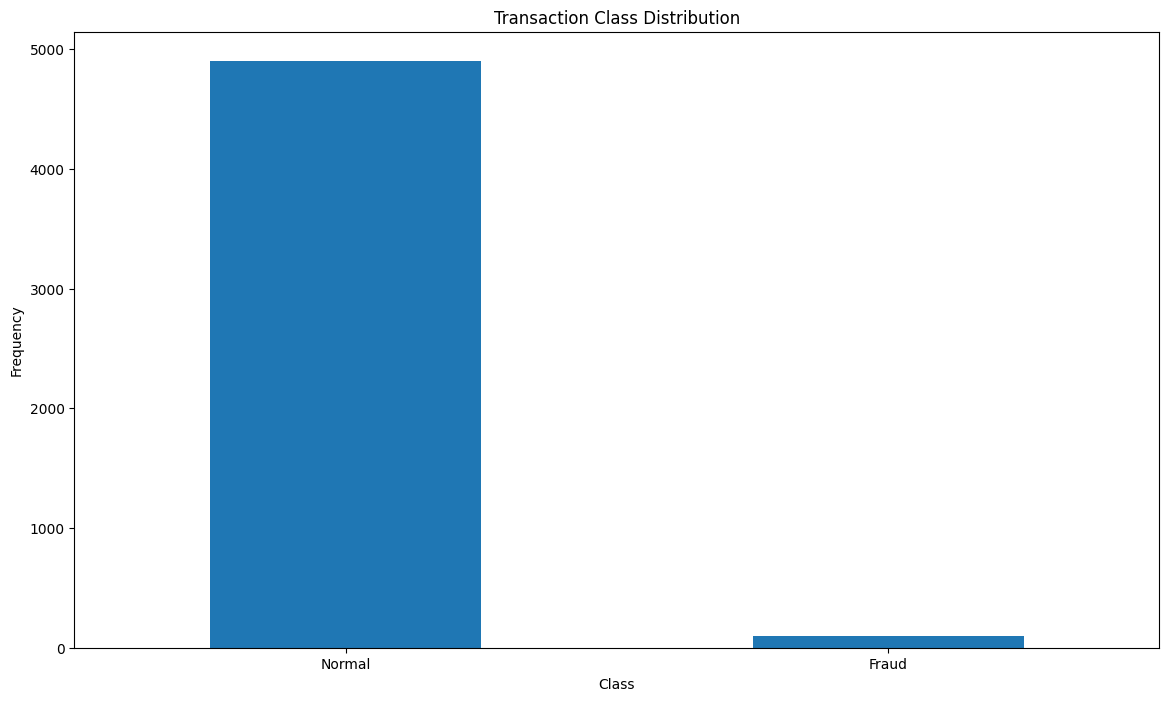

In [7]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [8]:
## Get the Fraud and the normal dataset

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [9]:
print(fraud.shape,normal.shape)

(100, 31) (4900, 31)


In [10]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

,Amount
count,100.000000
mean,445.286901
std,274.577444
min,1.905209
25%,231.479064
50%,436.057206
75%,652.115634
max,999.508250


In [11]:
normal.Amount.describe()

,Amount
count,4900.000000
mean,500.664013
std,289.051916
min,0.039585
25%,250.028094
50%,506.405440
75%,753.280645
max,999.796788


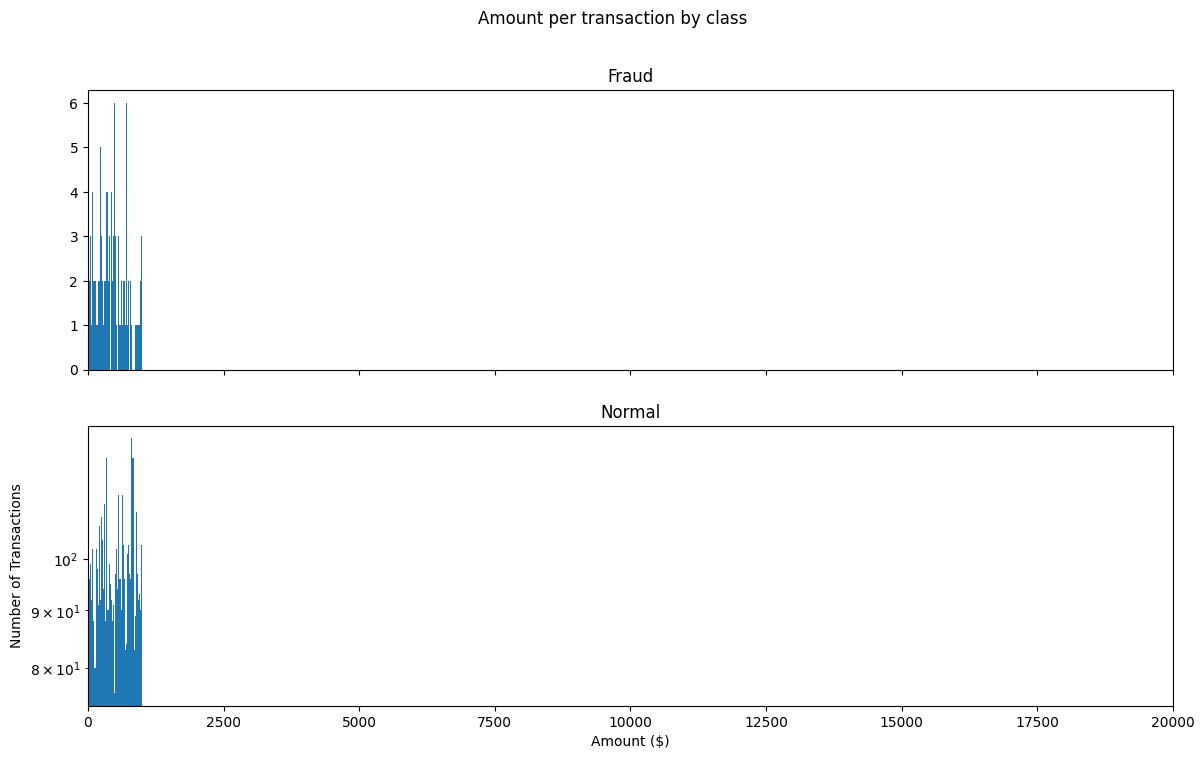

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

NameError: name 'Fraud' is not defined

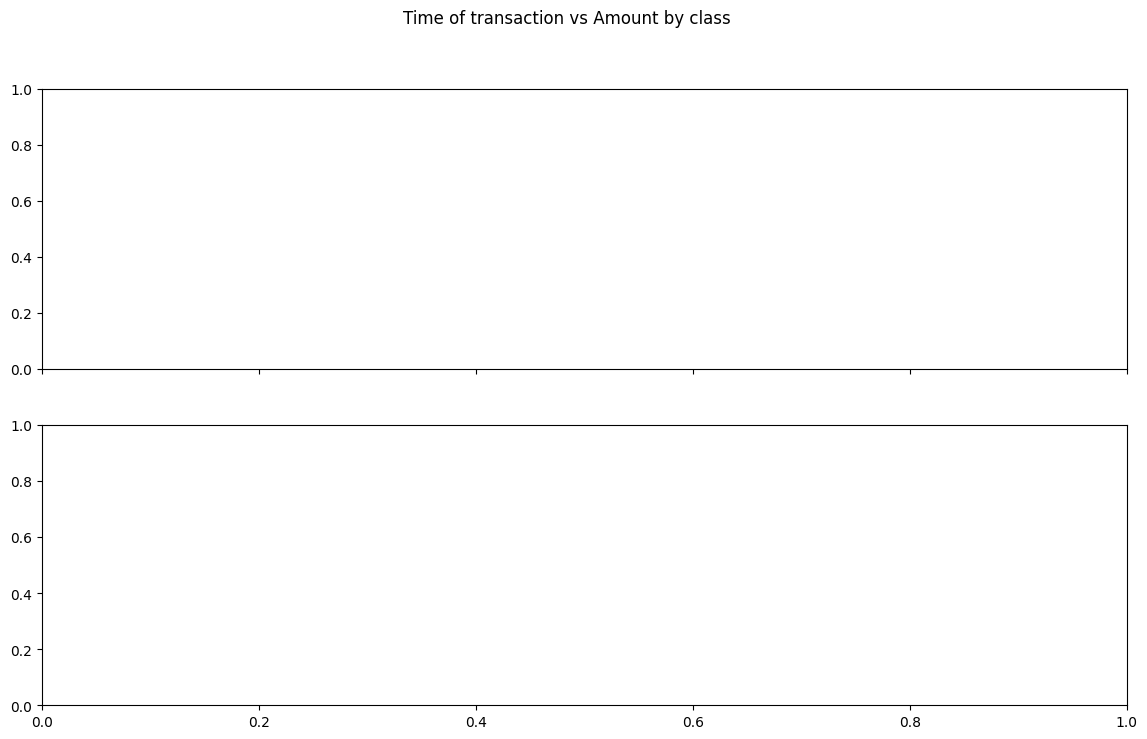

In [13]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [14]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(500, 31)

In [15]:
data.shape

(5000, 31)

In [16]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [17]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.035196687370600416
Fraud Cases : 17
Valid Cases : 483


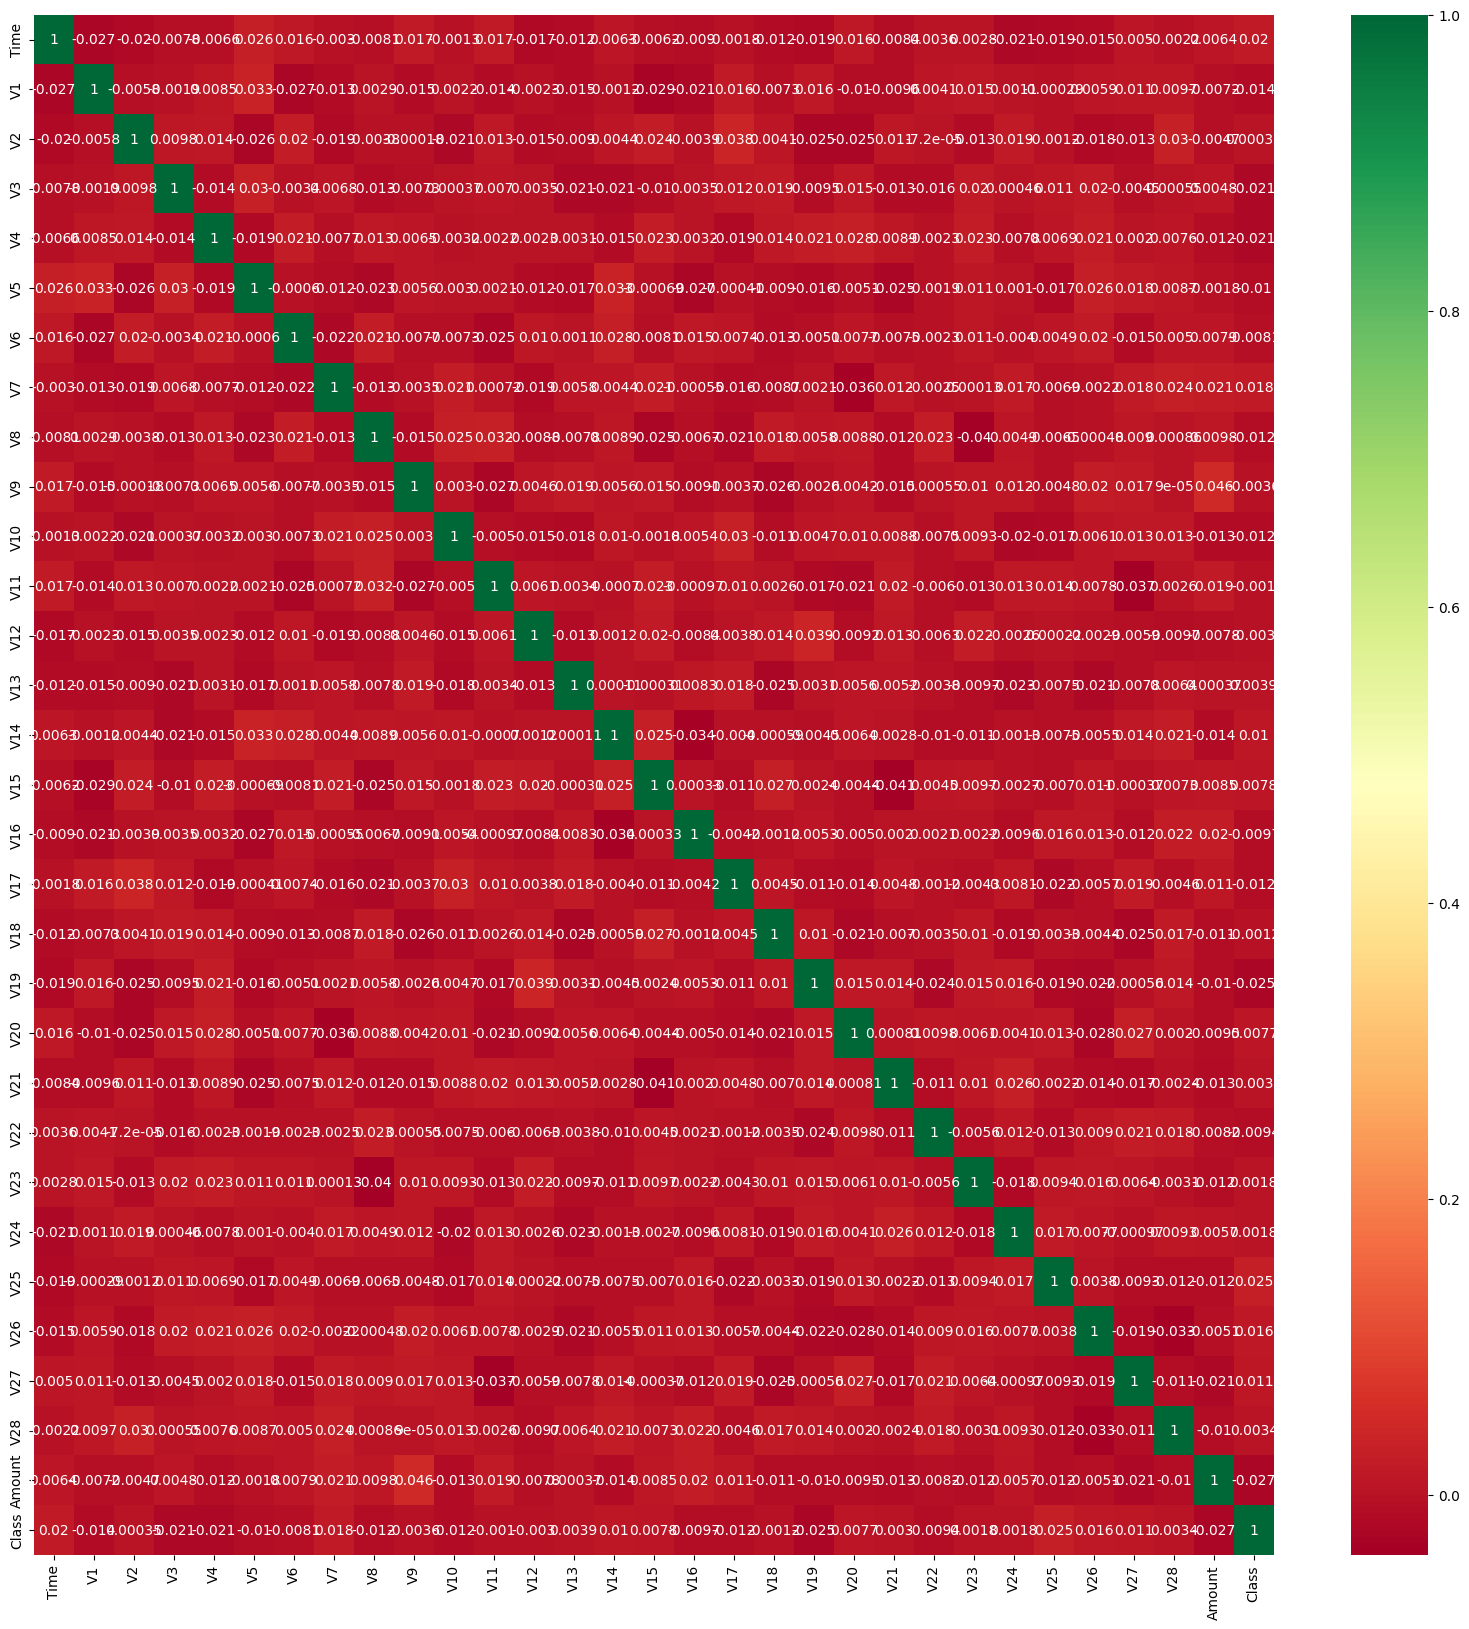

In [18]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [19]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(500, 30)
(500,)


## Model Prediction





Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [21]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest": IsolationForest(
        n_estimators=100,
        max_samples=len(X),
        contamination=outlier_fraction,
        random_state=state,
        verbose=0
    ),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        algorithm='auto',
        leaf_size=30,
        metric='minkowski',
        p=2,
        metric_params=None,
        contamination=outlier_fraction
    ),
    "Support Vector Machine": OneClassSVM(
        kernel='rbf',
        degree=3,
        gamma=0.1,
        nu=0.05,
        max_iter=-1
    )
}


In [ ]:
type(classifiers)

dict

In [22]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 33
Accuracy Score :
0.934
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       483
           1       0.06      0.06      0.06        17

    accuracy                           0.93       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.94      0.93      0.93       500

Local Outlier Factor: 35
Accuracy Score :
0.93
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       483
           1       0.00      0.00      0.00        17

    accuracy                           0.93       500
   macro avg       0.48      0.48      0.48       500
weighted avg       0.93      0.93      0.93       500

Support Vector Machine: 387
Accuracy Score :
0.226
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.20      0.34       483
           1       0.04

#### Observations :
- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases